In [1]:
import numpy as np
import torch
import pyepo

# random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
num_node = 50 # node size
num_data = 1000 # number of training data
num_feat = 10 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.tsp.genData(num_data+100+1000, num_feat, num_node, deg, e, seed=42)

In [3]:
from model import tspDFJModel
# set solver
optmodel = tspDFJModel(num_node)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
tour = optmodel.getTour(sol)
print(" -> ".join(map(str, tour)))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-22
Obj: 83.2537
0 -> 5 -> 3 -> 31 -> 42 -> 21 -> 13 -> 7 -> 18 -> 44 -> 36 -> 2 -> 27 -> 11 -> 47 -> 30 -> 10 -> 25 -> 46 -> 19 -> 6 -> 14 -> 39 -> 26 -> 35 -> 33 -> 49 -> 8 -> 22 -> 9 -> 24 -> 15 -> 29 -> 48 -> 17 -> 34 -> 32 -> 4 -> 43 -> 45 -> 23 -> 20 -> 12 -> 41 -> 40 -> 28 -> 38 -> 1 -> 37 -> 16 -> 0


In [4]:
# split data
from sklearn.model_selection import train_test_split
feats, x_test, costs, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)
x_train, x_val, c_train, c_val = train_test_split(feats, costs, test_size=100, random_state=42)

In [5]:
# get training, validation and test dataset
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train)
dataset_val = pyepo.data.dataset.optDataset(optmodel, x_val, costs=c_val)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:54<00:00, 18.32it/s]


Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.40it/s]


Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:55<00:00, 18.13it/s]


In [6]:
from dataset import optDatasetConstrs
dataset_train = optDatasetConstrs(optmodel, x_train, costs=c_train) # with binding constr

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:48<00:00,  4.38it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
from dataset import collate_fn
batch_size = 32
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_train = DataLoader(dataset_train, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, num_node*(num_node-1)//2)

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt

def plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw grad plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(grad_log, color="g", alpha=0.5, lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.gca().yaxis.get_offset_text().set_size(24)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Abs Grad", fontsize=36)
    plt.title("Absolute Gradient Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    fig = plt.figure(figsize=(16, 8))
    plt.plot([i * log_step for i in range(len(regret_log_trn))], regret_log_trn,
             color="royalblue", ls="--", alpha=0.7, lw=5, label="Train")
    plt.plot([i * log_step for i in range(len(regret_log_val))], regret_log_val,
             color="lightcoral", ls=":", alpha=0.7, lw=5, label="Val")
    plt.xlim(-0.5, num_epochs+0.5)
    plt.ylim(0, 0.8)
    plt.xticks(range(0, num_epochs+1, 5), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.legend(fontsize=32)
    plt.title("Regret Curve on Training and Validation Set", fontsize=36)
    plt.show()

## Train

In [10]:
num_epochs = 20
log_step = 1

In [11]:
import copy
import time
from tqdm import tqdm
from earlystop import earlyStopper

def pipeline(reg, forward_func, loss_func, lr, num_epochs, log_step, loader_train, loader_val, loader_test, seed=42):
    # set random seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # set stopper
    stopper = earlyStopper(patience=3)
    stop = False
    # init best model
    best_model_state = copy.deepcopy(reg.state_dict())
    best_val_regret = float("inf")
    # init log
    loss_log = []
    grad_log = []
    regret_log_trn = []
    regret_log_val = []
    # running time
    elapsed = 0
    tbar = tqdm(range(num_epochs))
    for epoch in tbar:
        # eval & log
        if epoch % log_step == 0:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
            regret_log_val.append(regret_val)
            tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                       format(epoch, regret_trn*100, regret_val*100))
            # update best model
            if regret_val < best_val_regret:
                best_val_regret = regret_val
                best_model_state = copy.deepcopy(reg.state_dict())
            # early stop
            if stopper.stop(regret_val):
                print()
                stop = True
                print("Early Stop!")
                # restore best model
                reg.load_state_dict(best_model_state)
                break
        # training
        time.sleep(1)
        tick = time.time()
        for data in loader_train:
            # forward pass
            loss = forward_func(data, reg, loss_func, grad_log)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_log.append(loss.item())
            tbar.set_description("Epoch {:4.0f}, Loss: {:8.4f}".format(epoch, loss.item()))
        # record time
        tock = time.time()
        elapsed += tock - tick
    # no early stop
    if not stop:
        regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
        regret_log_trn.append(regret_trn)
        regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
        regret_log_val.append(regret_val)
        tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                   format(epoch, regret_trn*100, regret_val*100))
    print()
    print("Evaluation:")
    test_regret = pyepo.metric.regret(reg, optmodel, loader_test)
    print("Test Regret: {:.4f}%".format(test_regret*100))
    print("Training Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, grad_log, regret_log_trn, regret_log_val

### Large Learning Rate 

In [12]:
# init model
reg = LinearRegression()

In [13]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, solver="clarabel", processes=8)

def forwardCAVE(data, reg, loss_func, grad_log):
    # unzip data
    x, _, _, t_ctr = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, t_ctr)
    return loss

Num of cores: 8


In [14]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [01:10<?, ?it/s]

Epoch   0, Train Regret: 329.3519%, Val Regret: 337.8251%


Epoch    0, Loss:  -0.9987:   5%|██▌                                                 | 1/20 [04:58<1:13:05, 230.83s/it]

Epoch   1, Train Regret:  24.8975%, Val Regret:  31.6269%


Epoch    1, Loss:  -0.9995:  10%|█████▍                                                | 2/20 [06:53<49:12, 164.02s/it]

Epoch   2, Train Regret:  16.9064%, Val Regret:  23.9921%


Epoch    2, Loss:  -0.9995:  15%|████████                                              | 3/20 [08:54<40:39, 143.48s/it]

Epoch   3, Train Regret:  14.3854%, Val Regret:  20.0668%


Epoch    3, Loss:  -0.9998:  20%|██████████▊                                           | 4/20 [10:51<35:39, 133.72s/it]

Epoch   4, Train Regret:  13.0129%, Val Regret:  18.6321%


Epoch    4, Loss:  -0.9997:  25%|█████████████▌                                        | 5/20 [12:46<31:40, 126.68s/it]

Epoch   5, Train Regret:  11.9450%, Val Regret:  17.1419%


Epoch    5, Loss:  -0.9998:  30%|████████████████▏                                     | 6/20 [14:40<28:45, 123.27s/it]

Epoch   6, Train Regret:  11.6719%, Val Regret:  15.7406%


Epoch    6, Loss:  -0.9998:  35%|██████████████████▉                                   | 7/20 [16:33<26:00, 120.00s/it]

Epoch   7, Train Regret:  11.3950%, Val Regret:  17.1603%


Epoch    7, Loss:  -0.9999:  40%|█████████████████████▌                                | 8/20 [18:24<23:27, 117.29s/it]

Epoch   8, Train Regret:  10.9658%, Val Regret:  15.5436%


Epoch    8, Loss:  -0.9998:  45%|████████████████████████▎                             | 9/20 [20:19<21:16, 116.06s/it]

Epoch   9, Train Regret:  10.8905%, Val Regret:  15.7284%


Epoch    9, Loss:  -0.9998:  50%|██████████████████████████▌                          | 10/20 [22:14<19:13, 115.36s/it]

Epoch  10, Train Regret:  10.5449%, Val Regret:  15.1942%


Epoch   10, Loss:  -0.9999:  55%|█████████████████████████████▏                       | 11/20 [24:08<17:11, 114.66s/it]

Epoch  11, Train Regret:  10.4588%, Val Regret:  15.4273%


Epoch   11, Loss:  -0.9999:  60%|███████████████████████████████▊                     | 12/20 [26:04<15:20, 115.11s/it]

Epoch  12, Train Regret:  10.4474%, Val Regret:  14.9614%


Epoch   12, Loss:  -0.9998:  65%|██████████████████████████████████▍                  | 13/20 [27:59<13:26, 115.25s/it]

Epoch  13, Train Regret:  10.3725%, Val Regret:  15.0553%


Epoch   13, Loss:  -0.9999:  70%|█████████████████████████████████████                | 14/20 [29:54<11:31, 115.17s/it]

Epoch  14, Train Regret:  10.7163%, Val Regret:  15.0604%


Epoch   14, Loss:  -0.9999:  75%|███████████████████████████████████████▊             | 15/20 [31:49<10:36, 127.32s/it]


Epoch  15, Train Regret:  10.2246%, Val Regret:  16.4659%

Early Stop!

Evaluation:
Test Regret: 16.6170%
Training Elapsed Time: 838.95 Sec


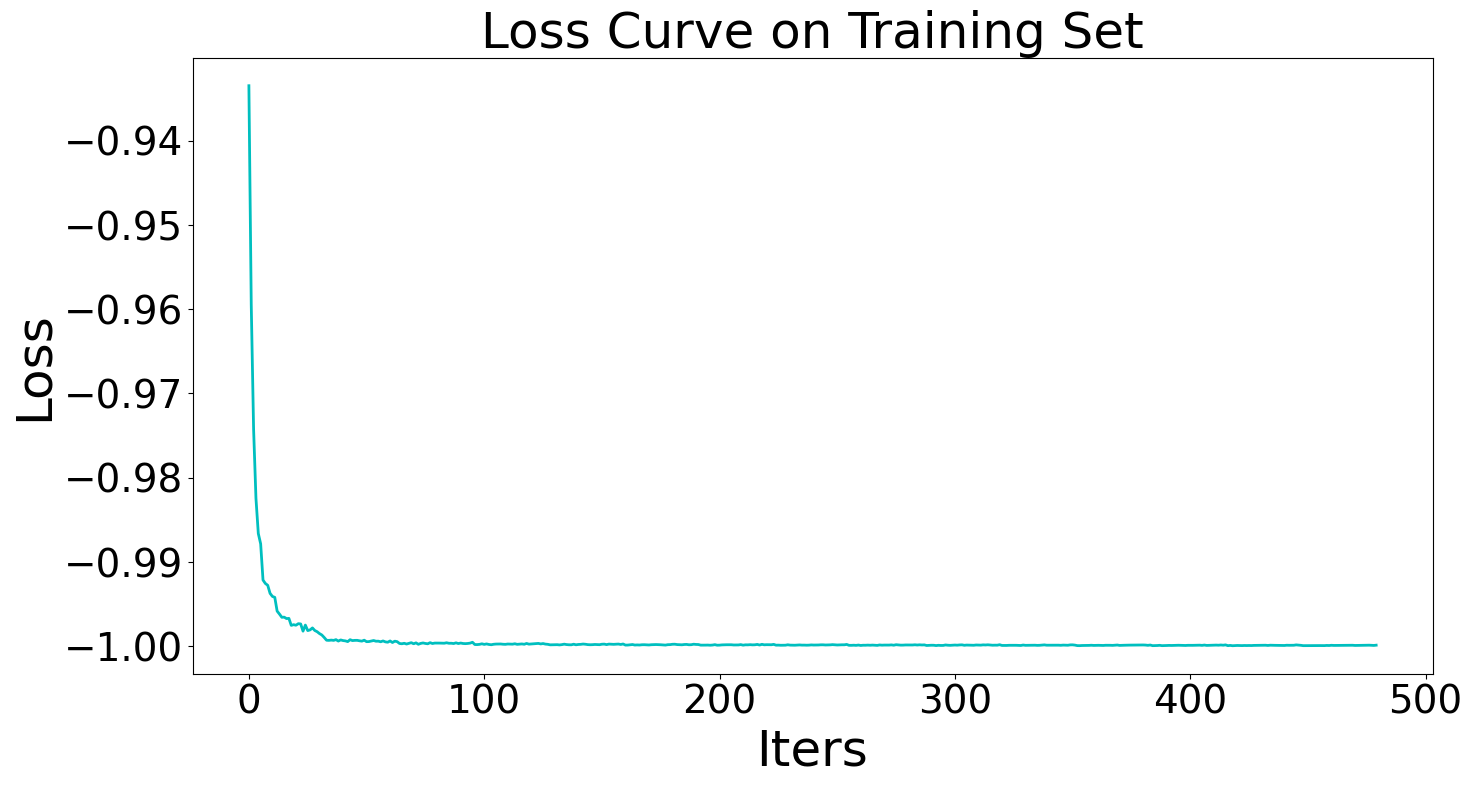

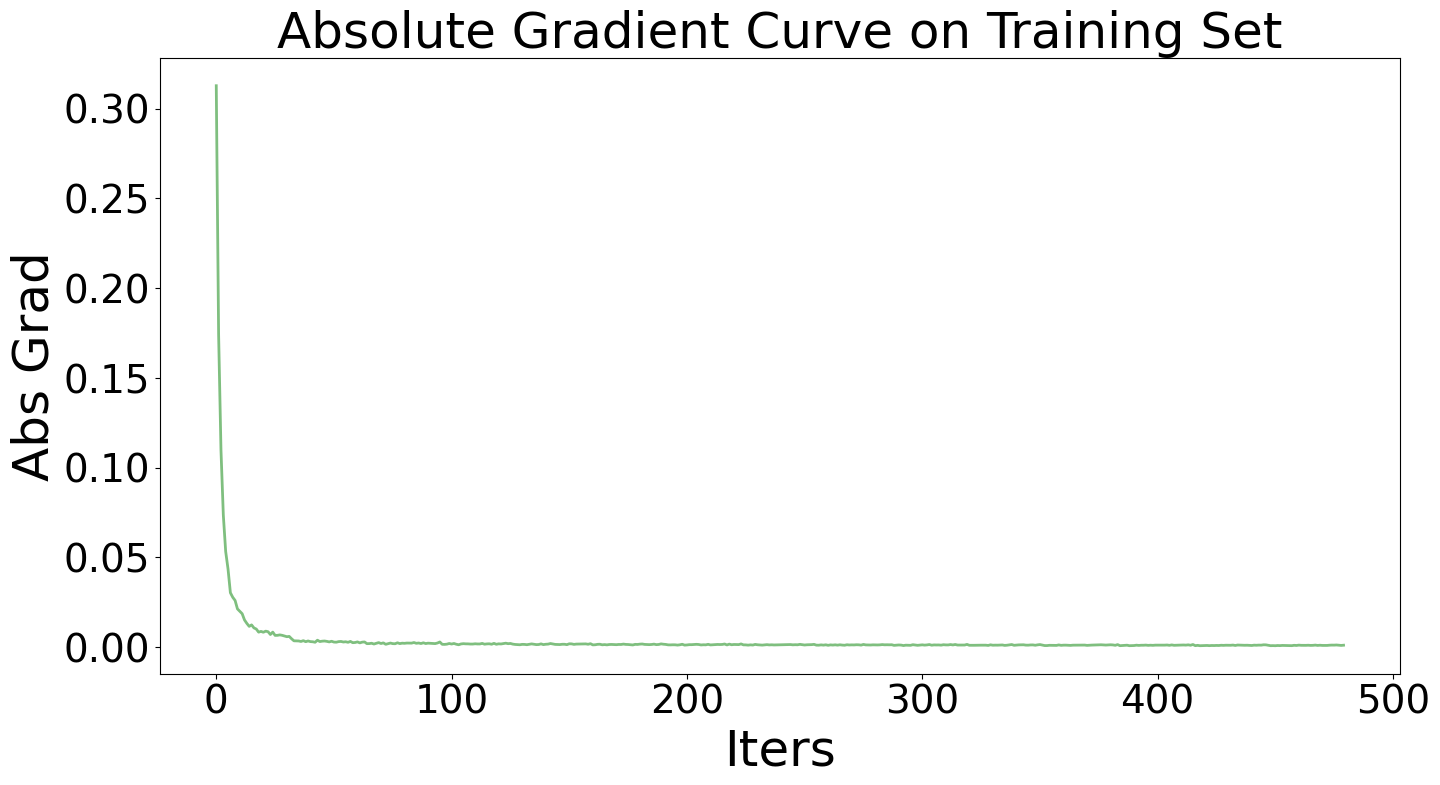

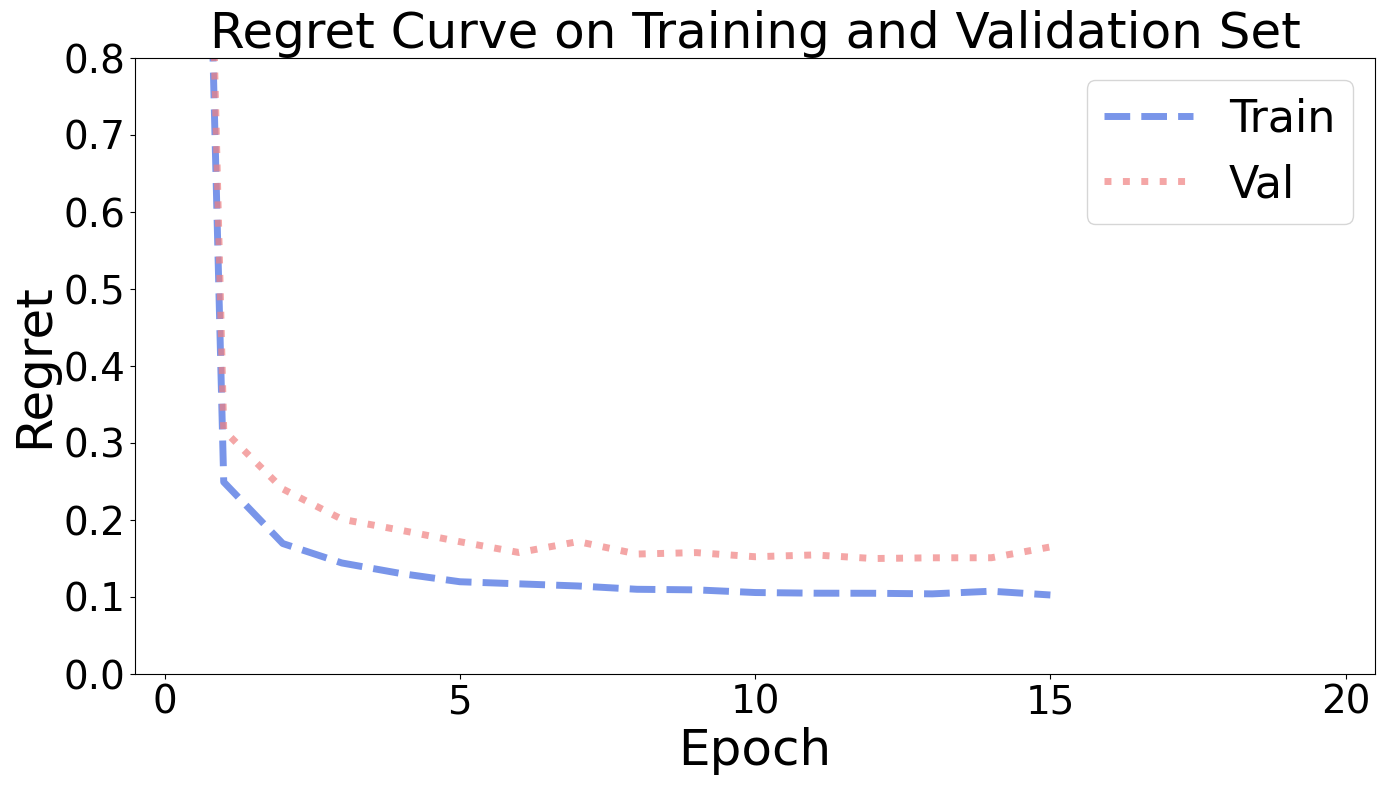

In [15]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

In [16]:
lr = 1e1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:58<?, ?it/s]

Epoch   0, Train Regret:  10.4437%, Val Regret:  14.9614%


Epoch    0, Loss:  -0.9982:   5%|██▋                                                   | 1/20 [02:55<34:07, 107.76s/it]

Epoch   1, Train Regret:  38.4661%, Val Regret:  45.9500%


Epoch    1, Loss:  -0.9994:  10%|█████▍                                                | 2/20 [04:56<33:58, 113.25s/it]

Epoch   2, Train Regret:  22.8319%, Val Regret:  27.5407%


Epoch    2, Loss:  -0.9996:  15%|████████                                              | 3/20 [06:54<39:11, 138.31s/it]


Epoch   3, Train Regret:  18.0433%, Val Regret:  24.0015%

Early Stop!

Evaluation:
Test Regret: 16.6170%
Training Elapsed Time: 145.31 Sec


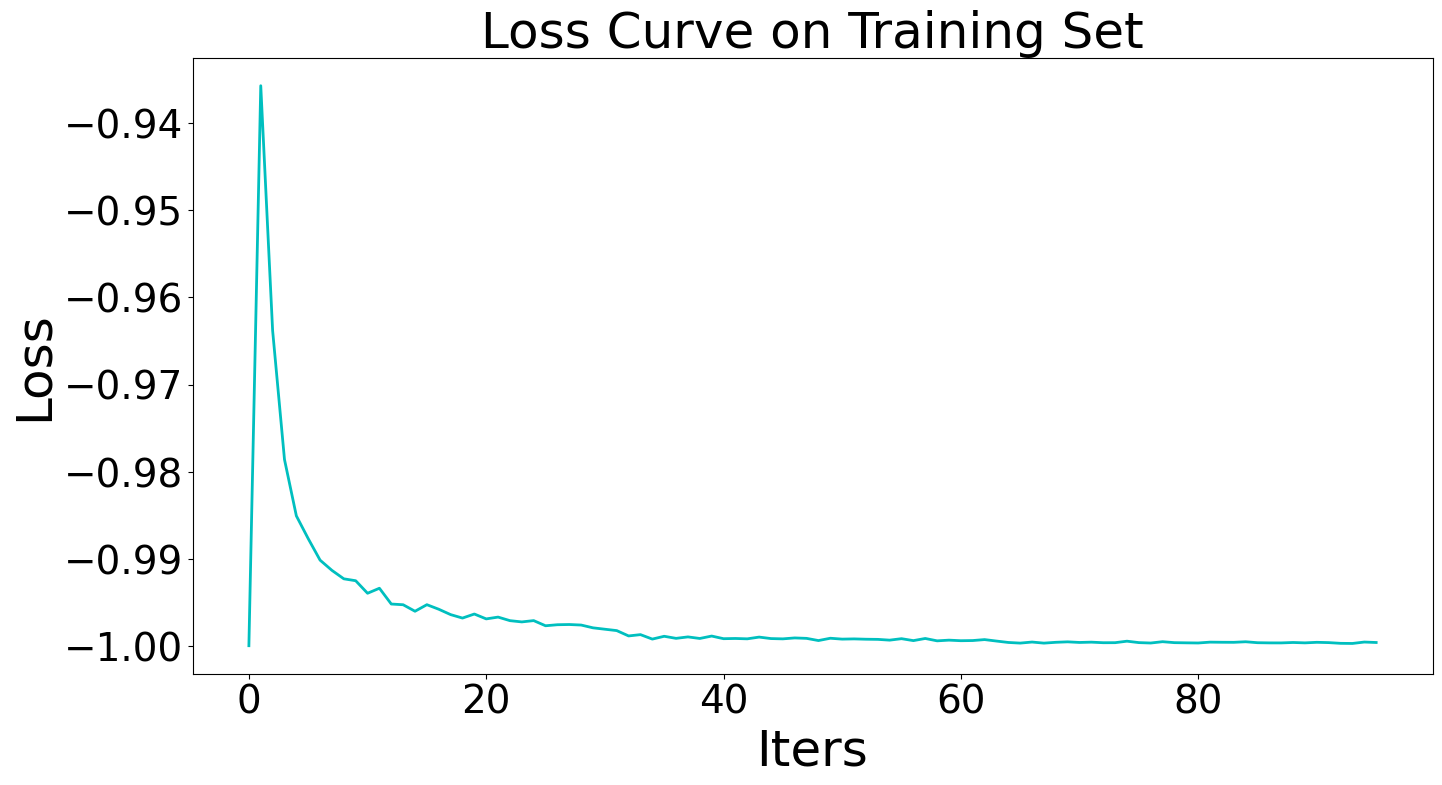

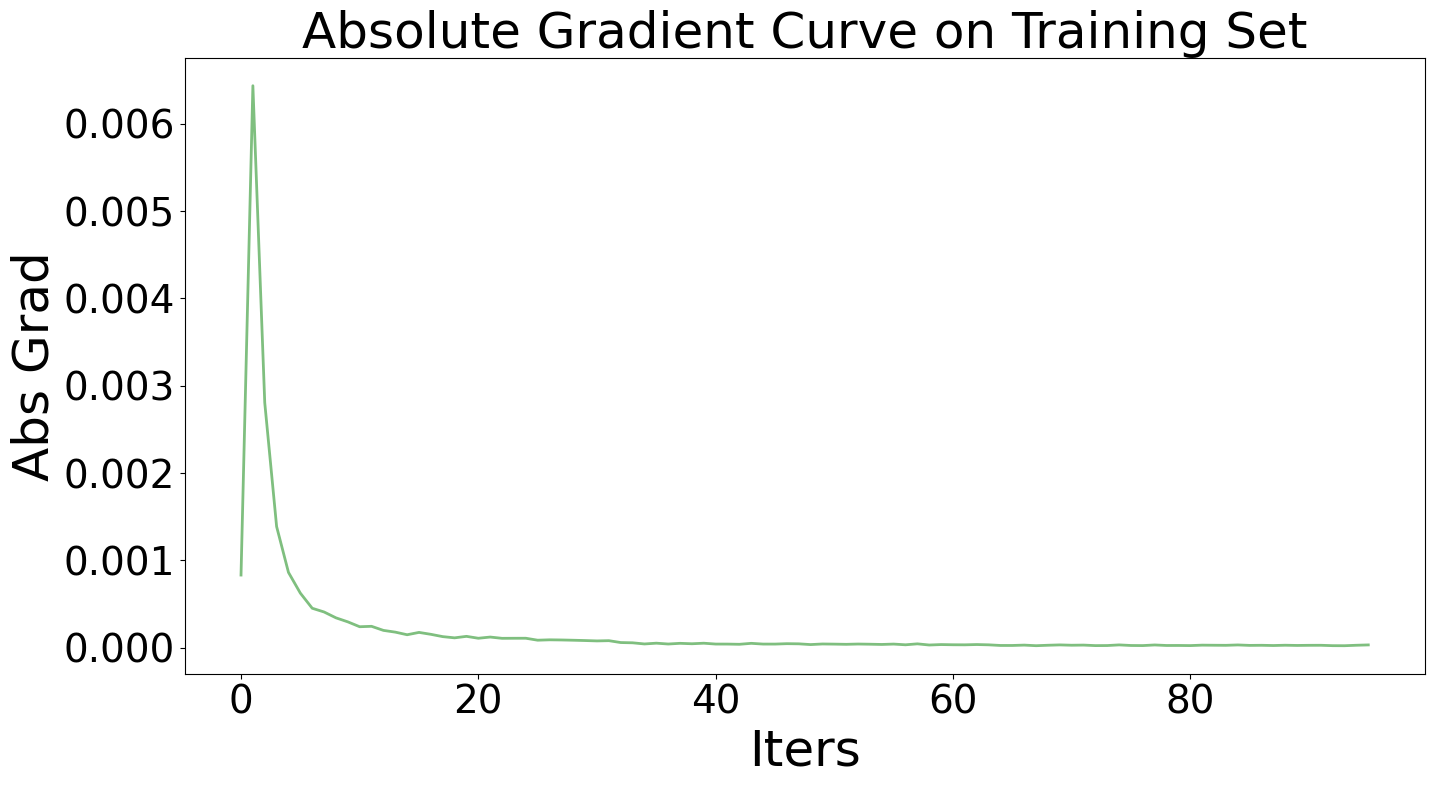

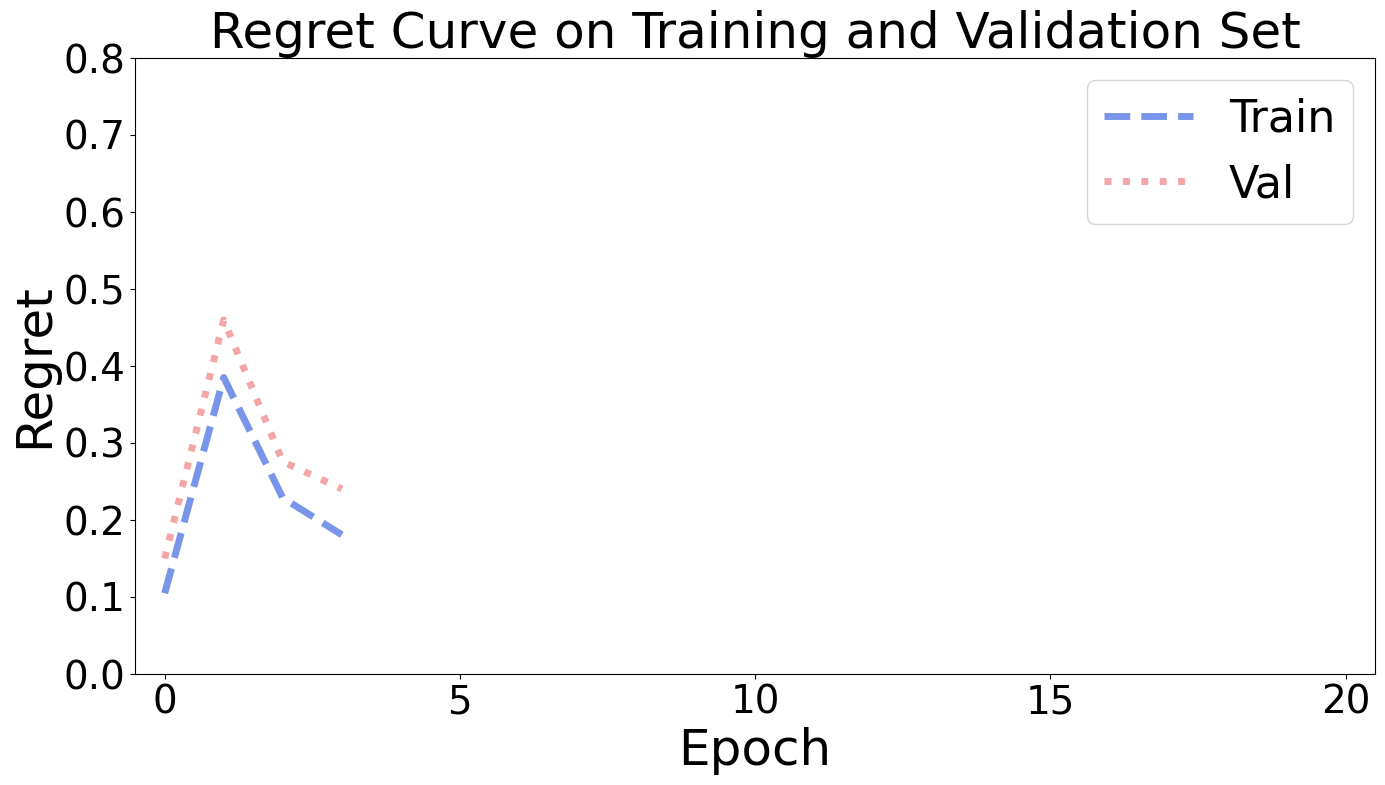

In [17]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Gradient Clip 

In [18]:
# init model
reg = LinearRegression()

In [19]:
def clip_gradients(model, threshold):
    for param in model.parameters():
        if param.grad is not None:
            with torch.no_grad():
                grad = param.grad
                grad[torch.abs(grad) < threshold] = 0

In [20]:
import copy
import time
from tqdm import tqdm
from earlystop import earlyStopper

def pipeline(reg, forward_func, loss_func, lr, num_epochs, log_step, loader_train, loader_val, loader_test, seed=42):
    # set random seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # set stopper
    stopper = earlyStopper(patience=3)
    stop = False
    # init best model
    best_model_state = copy.deepcopy(reg.state_dict())
    best_val_regret = float("inf")
    # init log
    loss_log = []
    grad_log = []
    regret_log_trn = []
    regret_log_val = []
    # running time
    elapsed = 0
    tbar = tqdm(range(num_epochs))
    for epoch in tbar:
        # eval & log
        if epoch % log_step == 0:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
            regret_log_val.append(regret_val)
            tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                       format(epoch, regret_trn*100, regret_val*100))
            # update best model
            if regret_val < best_val_regret:
                best_val_regret = regret_val
                best_model_state = copy.deepcopy(reg.state_dict())
            # early stop
            if stopper.stop(regret_val):
                print()
                stop = True
                print("Early Stop!")
                # restore best model
                reg.load_state_dict(best_model_state)
                break
        # training
        time.sleep(1)
        tick = time.time()
        for data in loader_train:
            # forward pass
            loss = forward_func(data, reg, loss_func, grad_log)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            clip_gradients(reg, threshold=1e-6) # clip
            optimizer.step()
            loss_log.append(loss.item())
            tbar.set_description("Epoch {:4.0f}, Loss: {:8.4f}".format(epoch, loss.item()))
        # record time
        tock = time.time()
        elapsed += tock - tick
    # no early stop
    if not stop:
        regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
        regret_log_trn.append(regret_trn)
        regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
        regret_log_val.append(regret_val)
        tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                   format(epoch, regret_trn*100, regret_val*100))
    print()
    print("Evaluation:")
    test_regret = pyepo.metric.regret(reg, optmodel, loader_test)
    print("Test Regret: {:.4f}%".format(test_regret*100))
    print("Training Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, grad_log, regret_log_trn, regret_log_val

In [21]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:56<?, ?it/s]

Epoch   0, Train Regret: 327.8377%, Val Regret: 344.5189%


Epoch    0, Loss:  -0.9987:   5%|██▋                                                   | 1/20 [02:56<34:12, 108.05s/it]

Epoch   1, Train Regret:  22.5968%, Val Regret:  24.8626%


Epoch    1, Loss:  -0.9995:  10%|█████▍                                                | 2/20 [04:55<34:16, 114.25s/it]

Epoch   2, Train Regret:  13.2068%, Val Regret:  16.2563%


Epoch    2, Loss:  -0.9996:  15%|████████                                              | 3/20 [06:52<32:58, 116.37s/it]

Epoch   3, Train Regret:  11.7143%, Val Regret:  15.0000%


Epoch    3, Loss:  -0.9997:  20%|██████████▊                                           | 4/20 [08:44<31:00, 116.27s/it]

Epoch   4, Train Regret:  11.3712%, Val Regret:  13.8941%


Epoch    4, Loss:  -0.9997:  25%|█████████████▌                                        | 5/20 [10:39<28:40, 114.72s/it]

Epoch   5, Train Regret:  10.7984%, Val Regret:  13.6277%


Epoch    5, Loss:  -0.9998:  30%|████████████████▏                                     | 6/20 [12:35<26:48, 114.86s/it]

Epoch   6, Train Regret:  10.1099%, Val Regret:  12.9301%


Epoch    6, Loss:  -0.9997:  35%|██████████████████▉                                   | 7/20 [14:27<24:56, 115.13s/it]

Epoch   7, Train Regret:   9.9044%, Val Regret:  13.1962%


Epoch    7, Loss:  -0.9999:  40%|█████████████████████▌                                | 8/20 [16:20<22:47, 113.96s/it]

Epoch   8, Train Regret:   9.9906%, Val Regret:  13.0661%


Epoch    8, Loss:  -0.9998:  45%|████████████████████████▎                             | 9/20 [18:15<20:47, 113.40s/it]

Epoch   9, Train Regret:   9.6703%, Val Regret:  12.0678%


Epoch    9, Loss:  -0.9998:  50%|██████████████████████████▌                          | 10/20 [20:07<19:06, 114.70s/it]

Epoch  10, Train Regret:   9.5438%, Val Regret:  12.3912%


Epoch   10, Loss:  -0.9998:  55%|█████████████████████████████▏                       | 11/20 [22:01<16:57, 113.11s/it]

Epoch  11, Train Regret:   9.3750%, Val Regret:  12.2747%


Epoch   11, Loss:  -0.9998:  60%|███████████████████████████████▊                     | 12/20 [23:59<15:59, 119.94s/it]


Epoch  12, Train Regret:   9.3648%, Val Regret:  13.1794%

Early Stop!

Evaluation:
Test Regret: 12.4456%
Training Elapsed Time: 577.30 Sec


In [22]:
lr = 1e1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:58<?, ?it/s]

Epoch   0, Train Regret:   9.6607%, Val Regret:  12.0678%


Epoch    0, Loss:  -0.9899:   5%|██▋                                                   | 1/20 [02:54<33:26, 105.59s/it]

Epoch   1, Train Regret:  60.5082%, Val Regret:  63.9752%


Epoch    1, Loss:  -0.9929:  10%|█████▍                                                | 2/20 [04:43<33:31, 111.76s/it]

Epoch   2, Train Regret:  58.0417%, Val Regret:  61.1557%


Epoch    2, Loss:  -0.9928:  15%|████████                                              | 3/20 [06:34<37:16, 131.55s/it]


Epoch   3, Train Regret:  57.4436%, Val Regret:  60.2693%

Early Stop!

Evaluation:
Test Regret: 12.4456%
Training Elapsed Time: 138.02 Sec
